In [2]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce this behaviour change. A possible replacement is to fix the wheel build issue repo

Episode: 0, Reward: -1548.4157017555945
Episode: 1, Reward: -1171.7144585212907
Episode: 2, Reward: -631.8250407210537
Episode: 3, Reward: -1403.8652160653378
Episode: 4, Reward: -1246.6808951673156
Episode: 5, Reward: -1117.1848309633876
Episode: 6, Reward: -877.039762689036
Episode: 7, Reward: -1515.3243233122414
Episode: 8, Reward: -1773.0048122614803
Episode: 9, Reward: -961.8668764185849
Episode: 10, Reward: -1247.8510353781585
Episode: 11, Reward: -752.2967605675639
Episode: 12, Reward: -1281.3196020858175
Episode: 13, Reward: -1165.0161441904768
Episode: 14, Reward: -1498.0153071214766
Episode: 15, Reward: -1477.6530152454643
Episode: 16, Reward: -1078.983474994124
Episode: 17, Reward: -1415.546981173782
Episode: 18, Reward: -1165.850394689213
Episode: 19, Reward: -658.3954011388453
Episode: 20, Reward: -1294.5445720933044
Episode: 21, Reward: -1276.0503450898918
Episode: 22, Reward: -858.0004453041469
Episode: 23, Reward: -664.5161768510507
Episode: 24, Reward: -1632.6586225944

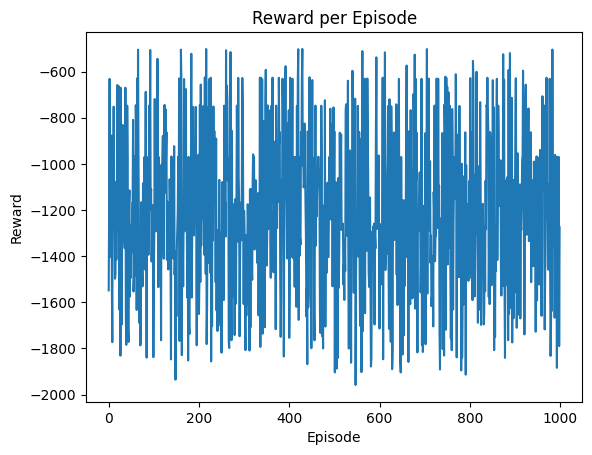

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import gym

class SAC:
    def __init__(self, env_name):
        self.env_name = env_name
        self.env = gym.make(env_name)
        self.action_space = self.env.action_space.shape[0]
        self.state_space = self.env.observation_space.shape[0]
        self.actor_model = self.get_actor()
        self.critic_model = self.get_critic()
        self.target_critic_model = self.get_critic()
        self.target_critic_model.set_weights(self.critic_model.get_weights())
        self.alpha = 0.2
        self.gamma = 0.99
        self.tau = 0.005
        self.buffer = []
        self.batch_size = 64

    def get_actor(self):
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
        inputs = layers.Input(shape=(self.state_space,))
        out = layers.Dense(256, activation="relu")(inputs)
        out = layers.Dense(256, activation="relu")(out)
        outputs = layers.Dense(self.action_space, activation="tanh", kernel_initializer=last_init)(out)
        model = tf.keras.Model(inputs, outputs)
        return model

    def get_critic(self):
        state_input = layers.Input(shape=(self.state_space))
        state_out = layers.Dense(16, activation="relu")(state_input)
        state_out = layers.Dense(32, activation="relu")(state_out)

        action_input = layers.Input(shape=(self.action_space))
        action_out = layers.Dense(32, activation="relu")(action_input)

        concat = layers.Concatenate()([state_out, action_out])

        out = layers.Dense(256, activation="relu")(concat)
        out = layers.Dense(256, activation="relu")(out)
        outputs = layers.Dense(1)(out)

        model = tf.keras.Model([state_input, action_input], outputs)

        return model

    def update_target(self):
        new_weights = []
        target_variables = self.target_critic_model.weights
        for i, variable in enumerate(self.critic_model.weights):
            new_weights.append(variable * self.tau + target_variables[i] * (1 - self.tau))
        self.target_critic_model.set_weights(new_weights)

    def remember(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.buffer) < self.batch_size:
            return

        samples = np.random.choice(len(self.buffer), self.batch_size)
        samples = [self.buffer[i] for i in samples]

        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        for sample in samples:
            state, action, reward, next_state, done = sample
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)

        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards).reshape(-1, 1)
        next_states = np.array(next_states)
        dones = np.array(dones).reshape(-1, 1)

        target_actions = self.actor_model(next_states)
    def act(self,state):
      state=tf.expand_dims(tf.convert_to_tensor(state),0)
      actions=self.actor_model(state)
      return actions[0]

if __name__ == "__main__":
    env_name='Pendulum-v1'
    sac=SAC(env_name)

    num_episodes=1000
    episode_rewards=[]
    for episode in range(num_episodes):
      state=sac.env.reset()
      episode_reward=0
      done=False
      while not done:
          action=sac.act(state)
          next_state,reward,done,_=sac.env.step(action.numpy())
          sac.remember(state,action,reward,next_state,int(done))
          sac.train()
          episode_reward+=reward
          state=next_state

      episode_rewards.append(episode_reward)
      print(f'Episode: {episode}, Reward: {episode_reward}')

    plt.plot(episode_rewards)
    plt.title('Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()